In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
N = 1000  # Some were run with 5000 oops, so we'll just use 1000 for consistency

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [os.path.join('analysis_restarts_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_restarts_v7.0'))]

In [5]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [6]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [7]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [8]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [9]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [10]:
remove_invalid = []

for model, model_results in results.items():
    pbar = tqdm(model_results.items(), desc=f'Loading {model} results')
    for test_set, test_set_results in pbar:
        pbar.set_postfix_str(test_set)
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)
            
            for k, v in test_set_results['data'].items():
                test_set_results['data'][k] = v[:N]

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_restarts_v7.0/v7.0_32-restarts results: 100%|██████████| 4/4 [00:23<00:00,  5.75s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_4-restarts results: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_2-restarts results: 100%|██████████| 4/4 [00:21<00:00,  5.45s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_128-restarts results: 100%|██████████| 4/4 [00:17<00:00,  4.26s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_1-restarts results: 100%|██████████| 4/4 [00:21<00:00,  5.37s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_8-restarts results: 100%|██████████| 4/4 [00:20<00:00,  5.04s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_64-restarts results: 100%|██████████| 4/4 [00:15<00:00,  3.97s/it, pool_15] 
Loading analysis_restarts_v7.0/v7.0_16-restarts results: 100%|██████████| 4/4 [00:20<00:00,  5.08s/it, pool_15] 


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 6472.69it/s]


In [12]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 4/4 [00:00<00:00, 9305.17it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 122.05it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 26.96it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(max(1 - r2, np.finfo(np.float32).eps)) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [16]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_rec

In [17]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [18]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [19]:
from functools import partial

In [20]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [21]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_restarts_v7.0/v7.0_32-restarts feynman:  52%|█████▏    | 25/48 [00:03<00:02,  9.18it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_restarts_v7.0/v7.0_128-restarts feynman: 100%|██████████| 48/48 [00:05<00:00,  8.12it/s]
analysis_restarts_v7.0/v7.0_128-restarts soose_nc: 100%|██████████| 48/48 [00:05<00:00,  8.86it/s]
analysis_restarts_v7.0/v7.0_16-restarts pool_15: 100%|██████████| 48/48 [00:05<00:00,  9.02it/s]


In [22]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [23]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_4-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_2-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_128-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_1-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_8-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_64-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_restarts_v7.0/v7.0_16-restarts,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [24]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.913 (0.894, 0.93)","0.85 (0.827, 0.872)","0.86 (0.84, 0.881)","0.647 (0.617, 0.675)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.876 (0.856, 0.896)","0.821 (0.797, 0.844)","0.876 (0.856, 0.896)","0.641 (0.61, 0.672)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.859 (0.838, 0.881)","0.815 (0.789, 0.837)","0.877 (0.856, 0.898)","0.616 (0.588, 0.645)"
analysis_restarts_v7.0/v7.0_128-restarts,"0.929 (0.914, 0.945)","0.858 (0.837, 0.88)","0.895 (0.874, 0.913)","0.631 (0.602, 0.657)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.814 (0.789, 0.837)","0.8 (0.774, 0.824)","0.861 (0.839, 0.881)","0.596 (0.566, 0.624)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.89 (0.871, 0.909)","0.833 (0.809, 0.857)","0.881 (0.861, 0.9)","0.643 (0.612, 0.669)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.915 (0.899, 0.93)","0.833 (0.808, 0.855)","0.871 (0.85, 0.892)","0.652 (0.621, 0.68)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.905 (0.888, 0.922)","0.829 (0.804, 0.853)","0.878 (0.859, 0.897)","0.639 (0.61, 0.666)"


In [25]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.963 (0.951, 0.975)","0.905 (0.886, 0.923)","0.992 (0.986, 0.997)","0.819 (0.794, 0.842)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.927 (0.911, 0.942)","0.877 (0.857, 0.898)","0.984 (0.975, 0.992)","0.827 (0.802, 0.85)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.908 (0.89, 0.926)","0.872 (0.85, 0.892)","0.991 (0.985, 0.996)","0.772 (0.745, 0.798)"
analysis_restarts_v7.0/v7.0_128-restarts,"0.977 (0.967, 0.986)","0.916 (0.9, 0.934)","0.991 (0.984, 0.996)","0.84 (0.817, 0.861)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.877 (0.854, 0.898)","0.857 (0.836, 0.877)","0.985 (0.977, 0.992)","0.797 (0.771, 0.822)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.948 (0.934, 0.962)","0.89 (0.869, 0.909)","0.99 (0.983, 0.996)","0.822 (0.8, 0.844)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.966 (0.954, 0.977)","0.898 (0.879, 0.915)","0.99 (0.983, 0.996)","0.844 (0.821, 0.864)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.951 (0.937, 0.965)","0.888 (0.867, 0.906)","0.989 (0.982, 0.995)","0.821 (0.798, 0.844)"


In [26]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.792 (0.765, 0.815)","0.747 (0.722, 0.774)","0.71 (0.679, 0.737)","0.359 (0.328, 0.389)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.754 (0.726, 0.781)","0.712 (0.685, 0.739)","0.747 (0.721, 0.774)","0.357 (0.327, 0.387)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.748 (0.722, 0.775)","0.71 (0.679, 0.734)","0.746 (0.72, 0.773)","0.331 (0.301, 0.36)"
analysis_restarts_v7.0/v7.0_128-restarts,"0.822 (0.797, 0.844)","0.754 (0.727, 0.777)","0.753 (0.727, 0.781)","0.36 (0.329, 0.389)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.7 (0.67, 0.726)","0.696 (0.667, 0.722)","0.744 (0.717, 0.771)","0.365 (0.337, 0.395)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.773 (0.748, 0.799)","0.728 (0.699, 0.756)","0.743 (0.717, 0.772)","0.36 (0.334, 0.391)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.793 (0.767, 0.816)","0.713 (0.685, 0.741)","0.732 (0.704, 0.761)","0.378 (0.348, 0.409)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.789 (0.763, 0.815)","0.723 (0.692, 0.749)","0.736 (0.71, 0.764)","0.334 (0.306, 0.364)"


In [27]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.789 (0.764, 0.815)","0.748 (0.72, 0.772)","0.709 (0.682, 0.737)","0.356 (0.327, 0.383)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.75 (0.723, 0.776)","0.709 (0.682, 0.738)","0.748 (0.719, 0.775)","0.357 (0.327, 0.387)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.748 (0.72, 0.774)","0.708 (0.68, 0.736)","0.742 (0.717, 0.768)","0.333 (0.304, 0.361)"
analysis_restarts_v7.0/v7.0_128-restarts,"0.816 (0.791, 0.84)","0.751 (0.725, 0.778)","0.752 (0.724, 0.78)","0.352 (0.323, 0.38)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.7 (0.673, 0.727)","0.695 (0.663, 0.722)","0.742 (0.713, 0.768)","0.362 (0.334, 0.391)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.773 (0.746, 0.8)","0.726 (0.698, 0.754)","0.746 (0.717, 0.772)","0.351 (0.322, 0.379)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.785 (0.757, 0.809)","0.71 (0.68, 0.737)","0.73 (0.702, 0.758)","0.375 (0.345, 0.406)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.788 (0.763, 0.815)","0.719 (0.689, 0.746)","0.739 (0.711, 0.768)","0.327 (0.3, 0.356)"


#### Numeric Error

In [28]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.092 (0.057, 0.132)","0.259 (0.21, 0.313)","0.007 (0.003, 0.014)","0.223 (0.132, 0.399)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.211 (0.166, 0.263)","0.379 (0.32, 0.443)","0.011 (0.006, 0.018)","0.182 (0.157, 0.211)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.802 (0.244, 2.094)","0.402 (0.338, 0.468)","0.005 (0.003, 0.008)","1.2038975532970885e+24 (0.215, 3.7282379293856..."
analysis_restarts_v7.0/v7.0_128-restarts,"0.054 (0.028, 0.086)","0.277 (0.221, 0.332)","0.008 (0.003, 0.014)","2.322 (0.113, 6.94)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.333 (0.283, 0.386)","0.401 (0.344, 0.462)","0.026 (0.012, 0.042)","0.69 (0.231, 1.585)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.168 (0.122, 0.221)","0.304 (0.253, 0.356)","0.009 (0.004, 0.016)","0.181 (0.154, 0.209)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.1 (0.062, 0.142)","1.193 (0.217, 3.252)","0.01 (0.004, 0.018)","0.125 (0.104, 0.146)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.119 (0.084, 0.157)","0.344 (0.289, 0.405)","0.009 (0.005, 0.015)","0.173 (0.147, 0.199)"


In [29]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"149838.785 (0.308, 485536.608)","81.252 (0.453, 260.062)","0.007 (0.003, 0.015)","1.2955038321794803e+17 (1.462, 4.0690531154246..."
analysis_restarts_v7.0/v7.0_4-restarts,"6912.137 (0.95, 22641.355)","0.818 (0.416, 1.794)","0.012 (0.007, 0.018)","75019.511 (2.809, 232962.838)"
analysis_restarts_v7.0/v7.0_2-restarts,"57.972 (0.81, 186.05)","250.296 (1.043, 794.995)","0.005 (0.003, 0.008)","1.8839072719321828e+37 (1.882, 5.9552773270474..."
analysis_restarts_v7.0/v7.0_128-restarts,"11.919 (0.106, 37.915)","0.773 (0.319, 1.531)","0.008 (0.003, 0.014)","1.3099515335086419e+20 (10.873, 4.086874291481..."
analysis_restarts_v7.0/v7.0_1-restarts,"4.534 (1.617, 8.642)","0.867 (0.591, 1.236)","0.027 (0.013, 0.044)","38.518 (2.117, 112.248)"
analysis_restarts_v7.0/v7.0_8-restarts,"117.628 (1.335, 451.931)","3.444 (0.391, 9.725)","0.009 (0.004, 0.017)","2.7067487220759994e+17 (5.725, 8.3908250327077..."
analysis_restarts_v7.0/v7.0_64-restarts,"313808.077 (0.429, 1069758.348)","2.13 (0.64, 4.83)","0.01 (0.004, 0.019)","2958694.274 (0.547, 7852674.779)"
analysis_restarts_v7.0/v7.0_16-restarts,"5.795 (0.604, 16.827)","3.519 (1.0, 8.083)","0.01 (0.004, 0.016)","3408532.892 (3.167, 10519312.175)"


#### Time

In [30]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"2.334 (2.312, 2.363)","2.258 (2.233, 2.286)","2.556 (2.532, 2.586)","2.705 (2.662, 2.752)"
analysis_restarts_v7.0/v7.0_4-restarts,"1.93 (1.92, 1.944)","1.929 (1.921, 1.944)","1.965 (1.953, 1.975)","2.014 (1.995, 2.033)"
analysis_restarts_v7.0/v7.0_2-restarts,"1.918 (1.906, 1.938)","1.935 (1.919, 1.948)","1.973 (1.958, 1.997)","2.038 (2.011, 2.073)"
analysis_restarts_v7.0/v7.0_128-restarts,"3.277 (3.208, 3.328)","3.05 (2.994, 3.115)","3.15 (3.06, 3.233)","3.702 (3.574, 3.824)"
analysis_restarts_v7.0/v7.0_1-restarts,"1.933 (1.912, 1.95)","1.947 (1.927, 1.963)","1.971 (1.957, 1.99)","2.144 (2.057, 2.294)"
analysis_restarts_v7.0/v7.0_8-restarts,"1.977 (1.959, 1.996)","1.96 (1.944, 1.974)","1.983 (1.971, 2.0)","2.081 (2.059, 2.1)"
analysis_restarts_v7.0/v7.0_64-restarts,"2.824 (2.776, 2.871)","2.801 (2.752, 2.832)","2.689 (2.65, 2.752)","3.094 (3.003, 3.199)"
analysis_restarts_v7.0/v7.0_16-restarts,"2.087 (2.072, 2.102)","2.039 (2.021, 2.054)","2.049 (2.034, 2.064)","2.22 (2.189, 2.255)"


In [31]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"2.334 (2.313, 2.363)","2.26 (2.231, 2.292)","2.557 (2.533, 2.583)","2.705 (2.669, 2.752)"
analysis_restarts_v7.0/v7.0_4-restarts,"1.93 (1.919, 1.944)","1.929 (1.921, 1.943)","1.966 (1.952, 1.975)","2.014 (1.995, 2.034)"
analysis_restarts_v7.0/v7.0_2-restarts,"1.918 (1.905, 1.939)","1.935 (1.919, 1.949)","1.973 (1.958, 1.997)","2.04 (2.011, 2.072)"
analysis_restarts_v7.0/v7.0_128-restarts,"3.274 (3.201, 3.329)","3.048 (2.99, 3.122)","3.149 (3.057, 3.239)","3.699 (3.575, 3.824)"
analysis_restarts_v7.0/v7.0_1-restarts,"1.933 (1.912, 1.951)","1.947 (1.928, 1.965)","1.972 (1.957, 1.987)","2.148 (2.058, 2.296)"
analysis_restarts_v7.0/v7.0_8-restarts,"1.976 (1.959, 1.996)","1.96 (1.944, 1.973)","1.983 (1.972, 2.0)","2.08 (2.059, 2.097)"
analysis_restarts_v7.0/v7.0_64-restarts,"2.823 (2.775, 2.867)","2.801 (2.753, 2.833)","2.688 (2.65, 2.743)","3.093 (2.997, 3.192)"
analysis_restarts_v7.0/v7.0_16-restarts,"2.089 (2.072, 2.102)","2.039 (2.022, 2.054)","2.049 (2.034, 2.064)","2.22 (2.19, 2.256)"


#### Text Metrics

In [32]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"2.291 (2.123, 2.508)","2.056 (1.912, 2.208)","5.315 (4.839, 5.977)","16.742 (14.397, 20.257)"
analysis_restarts_v7.0/v7.0_4-restarts,"2.109 (2.007, 2.314)","2.056 (1.911, 2.229)","5.676 (4.838, 6.662)","19.675 (16.518, 23.901)"
analysis_restarts_v7.0/v7.0_2-restarts,"2.266 (2.082, 2.501)","1.974 (1.872, 2.122)","4.946 (4.217, 5.691)","15.41 (12.798, 17.518)"
analysis_restarts_v7.0/v7.0_128-restarts,"2.178 (2.02, 2.421)","1.915 (1.824, 2.02)","4.707 (4.082, 5.623)","17.164 (14.077, 20.982)"
analysis_restarts_v7.0/v7.0_1-restarts,"2.207 (2.057, 2.451)","1.935 (1.805, 2.08)","5.572 (4.797, 6.13)","16.508 (13.978, 20.828)"
analysis_restarts_v7.0/v7.0_8-restarts,"2.265 (2.082, 2.52)","1.932 (1.827, 2.057)","4.724 (4.094, 5.631)","18.382 (15.821, 20.965)"
analysis_restarts_v7.0/v7.0_64-restarts,"2.259 (2.09, 2.578)","2.011 (1.888, 2.193)","5.809 (4.913, 6.398)","15.904 (12.881, 18.951)"
analysis_restarts_v7.0/v7.0_16-restarts,"2.397 (2.173, 2.709)","1.998 (1.87, 2.143)","5.134 (4.676, 6.089)","15.907 (13.739, 19.502)"


In [33]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"10.432 (9.835, 11.028)","7.675 (7.156, 8.217)","13.136 (12.385, 13.886)","22.504 (21.787, 23.297)"
analysis_restarts_v7.0/v7.0_4-restarts,"10.906 (10.294, 11.503)","7.706 (7.216, 8.252)","12.893 (12.165, 13.609)","22.25 (21.495, 23.005)"
analysis_restarts_v7.0/v7.0_2-restarts,"10.54 (9.947, 11.082)","7.424 (6.968, 7.975)","12.158 (11.441, 12.86)","21.921 (21.133, 22.659)"
analysis_restarts_v7.0/v7.0_128-restarts,"10.869 (10.27, 11.455)","7.342 (6.846, 7.874)","12.295 (11.573, 13.009)","22.172 (21.403, 22.868)"
analysis_restarts_v7.0/v7.0_1-restarts,"11.478 (10.91, 12.145)","7.047 (6.551, 7.535)","12.33 (11.568, 13.081)","22.188 (21.413, 23.058)"
analysis_restarts_v7.0/v7.0_8-restarts,"10.739 (10.193, 11.366)","7.505 (7.026, 8.068)","12.392 (11.656, 13.106)","22.205 (21.407, 22.967)"
analysis_restarts_v7.0/v7.0_64-restarts,"11.124 (10.521, 11.724)","7.978 (7.496, 8.568)","12.426 (11.709, 13.135)","22.136 (21.451, 22.884)"
analysis_restarts_v7.0/v7.0_16-restarts,"11.19 (10.605, 11.797)","7.703 (7.188, 8.232)","12.188 (11.459, 12.943)","22.066 (21.323, 22.793)"


In [34]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.92 (0.914, 0.925)","0.91 (0.903, 0.918)","0.83 (0.82, 0.839)","0.851 (0.844, 0.857)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.917 (0.911, 0.922)","0.909 (0.901, 0.917)","0.83 (0.821, 0.841)","0.858 (0.851, 0.865)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.921 (0.916, 0.926)","0.91 (0.902, 0.917)","0.837 (0.827, 0.847)","0.854 (0.848, 0.861)"
analysis_restarts_v7.0/v7.0_128-restarts,"0.92 (0.915, 0.925)","0.917 (0.91, 0.924)","0.837 (0.827, 0.846)","0.859 (0.853, 0.866)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.919 (0.913, 0.924)","0.913 (0.905, 0.922)","0.838 (0.829, 0.847)","0.855 (0.849, 0.862)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.918 (0.912, 0.923)","0.911 (0.903, 0.919)","0.839 (0.83, 0.849)","0.854 (0.847, 0.862)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.914 (0.908, 0.92)","0.911 (0.902, 0.919)","0.838 (0.829, 0.847)","0.854 (0.848, 0.861)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.916 (0.911, 0.922)","0.91 (0.902, 0.919)","0.836 (0.827, 0.846)","0.856 (0.85, 0.862)"


In [35]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"0.752 (0.737, 0.767)","0.793 (0.777, 0.809)","0.617 (0.598, 0.637)","0.519 (0.504, 0.533)"
analysis_restarts_v7.0/v7.0_4-restarts,"0.747 (0.732, 0.761)","0.785 (0.77, 0.8)","0.623 (0.602, 0.642)","0.529 (0.515, 0.544)"
analysis_restarts_v7.0/v7.0_2-restarts,"0.752 (0.738, 0.767)","0.787 (0.771, 0.802)","0.631 (0.611, 0.649)","0.52 (0.505, 0.535)"
analysis_restarts_v7.0/v7.0_128-restarts,"0.74 (0.726, 0.755)","0.8 (0.785, 0.815)","0.632 (0.613, 0.651)","0.53 (0.516, 0.545)"
analysis_restarts_v7.0/v7.0_1-restarts,"0.726 (0.713, 0.74)","0.799 (0.783, 0.814)","0.626 (0.607, 0.645)","0.524 (0.51, 0.539)"
analysis_restarts_v7.0/v7.0_8-restarts,"0.745 (0.729, 0.758)","0.791 (0.774, 0.806)","0.642 (0.622, 0.663)","0.53 (0.516, 0.545)"
analysis_restarts_v7.0/v7.0_64-restarts,"0.741 (0.727, 0.756)","0.784 (0.768, 0.8)","0.631 (0.612, 0.651)","0.527 (0.512, 0.542)"
analysis_restarts_v7.0/v7.0_16-restarts,"0.738 (0.723, 0.752)","0.789 (0.773, 0.804)","0.628 (0.608, 0.647)","0.529 (0.514, 0.543)"


In [36]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_restarts_v7.0/v7.0_32-restarts,"3.98 (3.799, 4.196)","2.847 (2.661, 3.037)","4.361 (4.108, 4.625)","8.888 (8.565, 9.196)"
analysis_restarts_v7.0/v7.0_4-restarts,"4.05 (3.853, 4.254)","2.831 (2.662, 3.015)","4.305 (4.026, 4.544)","8.869 (8.55, 9.179)"
analysis_restarts_v7.0/v7.0_2-restarts,"3.957 (3.752, 4.17)","2.815 (2.638, 2.999)","4.02 (3.789, 4.251)","8.818 (8.52, 9.128)"
analysis_restarts_v7.0/v7.0_128-restarts,"4.068 (3.867, 4.261)","2.726 (2.543, 2.906)","4.12 (3.866, 4.379)","8.813 (8.523, 9.11)"
analysis_restarts_v7.0/v7.0_1-restarts,"4.27 (4.066, 4.47)","2.722 (2.529, 2.902)","4.098 (3.86, 4.361)","8.979 (8.674, 9.307)"
analysis_restarts_v7.0/v7.0_8-restarts,"4.052 (3.867, 4.27)","2.757 (2.577, 2.938)","4.124 (3.881, 4.378)","8.809 (8.523, 9.097)"
analysis_restarts_v7.0/v7.0_64-restarts,"4.146 (3.941, 4.36)","2.975 (2.796, 3.166)","4.075 (3.835, 4.33)","8.862 (8.58, 9.143)"
analysis_restarts_v7.0/v7.0_16-restarts,"4.152 (3.961, 4.354)","2.828 (2.646, 3.02)","4.027 (3.792, 4.268)","8.786 (8.495, 9.097)"


In [37]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_restarts_v7.0/32-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*79.2\ (76.5, 81.5) <table_CI>*], [*74.7\ (72.2, 77.4) <table_CI>*], [*71.0\ (67.9, 73.7) <table_CI>*], [*35.9\ (32.8, 38.9) <table_CI>*],
  [analysis_restarts_v7.0/4-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [75.4\ (72.6, 78.1) <table_CI>], [*71.2\ (68.5, 73.9) <table_CI>*], [*74.7\ (72.1, 77.4) <table_CI>*], [*35.7\ (32.7, 38.7) <table_CI>*],
  [analysis_restarts_v7.0/2-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [7

In [39]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_restarts_v7.0/32-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*96.3\ (95.1, 97.5) <table_CI>*], [*90.5\ (88.6, 92.3) <table_CI>*], [*99.2\ (98.6, 99.7) <table_CI>*], [*81.9\ (79.4, 84.2) <table_CI>*],
  [analysis_restarts_v7.0/4-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [92.7\ (91.1, 94.2) <table_CI>], [87.7\ (85.7, 89.8) <table_CI>], [*98.4\ (97.5, 99.2) <table_CI>*], [*82.7\ (80.2, 85.0) <table_CI>*],
  [analysis_restarts_v7.0/2-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [90.

In [40]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_restarts_v7.0/32-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*3.98\ (3.80, 4.20) <table_CI>*], [*2.85\ (2.66, 3.04) <table_CI>*], [*4.36\ (4.11, 4.62) <table_CI>*], [*8.89\ (8.56, 9.20) <table_CI>*],
  [analysis_restarts_v7.0/4-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.05\ (3.85, 4.25) <table_CI>*], [*2.83\ (2.66, 3.02) <table_CI>*], [*4.30\ (4.03, 4.54) <table_CI>*], [*8.87\ (8.55, 9.18) <table_CI>*],
  [analysis_restarts_v7.0/2-restarts], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], 

# Aggregated

In [41]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_restarts_v7.0/v7.0_32-restarts:  52%|█████▏    | 25/48 [00:05<00:05,  4.48it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_restarts_v7.0/v7.0_16-restarts: 100%|██████████| 48/48 [00:10<00:00,  4.38it/s]


In [43]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [44]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_restarts_v7.0/v7.0_32-restarts,analysis_restarts_v7.0/v7.0_4-restarts,analysis_restarts_v7.0/v7.0_2-restarts,analysis_restarts_v7.0/v7.0_128-restarts,analysis_restarts_v7.0/v7.0_1-restarts,analysis_restarts_v7.0/v7.0_8-restarts,analysis_restarts_v7.0/v7.0_64-restarts,analysis_restarts_v7.0/v7.0_16-restarts
FVU-eps_accuracy,"0.652 (0.637, 0.667)","0.642 (0.629, 0.657)","0.634 (0.62, 0.648)","0.671 (0.656, 0.686)","0.626 (0.612, 0.642)","0.652 (0.637, 0.666)","0.654 (0.638, 0.67)","0.646 (0.631, 0.661)"
FVU-eps_accuracy_val,"0.65 (0.636, 0.665)","0.641 (0.626, 0.655)","0.632 (0.618, 0.648)","0.668 (0.652, 0.683)","0.624 (0.609, 0.64)","0.649 (0.634, 0.663)","0.65 (0.635, 0.664)","0.643 (0.628, 0.658)"
NSRTS_accuracy_close_best_beam,"0.818 (0.806, 0.83)","0.804 (0.792, 0.816)","0.791 (0.778, 0.804)","0.828 (0.817, 0.838)","0.768 (0.755, 0.781)","0.812 (0.8, 0.824)","0.817 (0.806, 0.829)","0.813 (0.801, 0.825)"
NSRTS_accuracy_close_val_best_beam,"0.816 (0.804, 0.828)","0.804 (0.792, 0.817)","0.791 (0.778, 0.803)","0.828 (0.818, 0.84)","0.767 (0.754, 0.78)","0.813 (0.8, 0.825)","0.817 (0.805, 0.829)","0.814 (0.802, 0.825)"
NSRTS_accuracy_r2_best_beam,"0.92 (0.912, 0.929)","0.904 (0.895, 0.914)","0.886 (0.876, 0.896)","0.931 (0.923, 0.938)","0.879 (0.868, 0.889)","0.912 (0.904, 0.921)","0.924 (0.916, 0.933)","0.912 (0.904, 0.922)"
NSRTS_accuracy_r2_val_best_beam,"0.911 (0.901, 0.919)","0.898 (0.889, 0.908)","0.882 (0.872, 0.891)","0.92 (0.912, 0.929)","0.874 (0.864, 0.884)","0.9 (0.89, 0.909)","0.917 (0.908, 0.924)","0.9 (0.892, 0.909)"
accuracy_best_beam,"0.258 (0.243, 0.27)","0.256 (0.243, 0.27)","0.259 (0.245, 0.274)","0.262 (0.249, 0.276)","0.266 (0.252, 0.281)","0.266 (0.252, 0.28)","0.254 (0.24, 0.268)","0.258 (0.245, 0.271)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


In [45]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_restarts_v7.0/v7.0_32-restarts,analysis_restarts_v7.0/v7.0_4-restarts,analysis_restarts_v7.0/v7.0_2-restarts,analysis_restarts_v7.0/v7.0_128-restarts,analysis_restarts_v7.0/v7.0_1-restarts,analysis_restarts_v7.0/v7.0_8-restarts,analysis_restarts_v7.0/v7.0_64-restarts,analysis_restarts_v7.0/v7.0_16-restarts
edit_distance_best_beam,"5.014 (4.888, 5.158)","5.014 (4.877, 5.149)","4.903 (4.768, 5.041)","4.932 (4.799, 5.073)","5.018 (4.869, 5.151)","4.938 (4.807, 5.086)","5.016 (4.881, 5.152)","4.955 (4.812, 5.085)"
tree_edit_distance_best_beam,"13.421 (13.054, 13.778)","13.428 (13.048, 13.809)","13.008 (12.674, 13.366)","13.165 (12.79, 13.525)","13.261 (12.908, 13.631)","13.215 (12.819, 13.594)","13.413 (13.036, 13.818)","13.286 (12.891, 13.638)"
f1_score_best_beam,"0.878 (0.874, 0.882)","0.878 (0.874, 0.882)","0.881 (0.877, 0.884)","0.883 (0.879, 0.887)","0.881 (0.877, 0.885)","0.881 (0.877, 0.884)","0.879 (0.875, 0.883)","0.88 (0.876, 0.884)"
meteor_best_beam,"0.67 (0.662, 0.679)","0.671 (0.662, 0.679)","0.672 (0.664, 0.681)","0.676 (0.667, 0.685)","0.669 (0.66, 0.678)","0.677 (0.668, 0.686)","0.671 (0.662, 0.679)","0.671 (0.661, 0.679)"
precision_best_beam,"0.894 (0.89, 0.898)","0.896 (0.892, 0.9)","0.898 (0.894, 0.902)","0.901 (0.897, 0.905)","0.9 (0.896, 0.904)","0.898 (0.894, 0.902)","0.896 (0.892, 0.9)","0.896 (0.892, 0.9)"
bleu_best_beam,"0.437 (0.426, 0.449)","0.442 (0.431, 0.454)","0.444 (0.432, 0.456)","0.447 (0.436, 0.459)","0.44 (0.428, 0.453)","0.446 (0.434, 0.458)","0.436 (0.424, 0.448)","0.44 (0.429, 0.452)"
recall_best_beam,"0.871 (0.866, 0.876)","0.871 (0.867, 0.876)","0.874 (0.869, 0.878)","0.876 (0.872, 0.881)","0.873 (0.868, 0.877)","0.874 (0.869, 0.879)","0.873 (0.867, 0.877)","0.875 (0.87, 0.879)"
rougeL_recall_best_beam,"0.717 (0.71, 0.724)","0.72 (0.714, 0.727)","0.723 (0.717, 0.729)","0.723 (0.717, 0.729)","0.723 (0.716, 0.729)","0.721 (0.715, 0.728)","0.717 (0.71, 0.723)","0.718 (0.712, 0.725)"
reciprocal_rank,"0.828 (0.824, 0.832)","0.829 (0.824, 0.833)","0.832 (0.827, 0.836)","0.831 (0.826, 0.835)","0.83 (0.826, 0.834)","0.832 (0.828, 0.837)","0.83 (0.826, 0.834)","0.829 (0.825, 0.833)"
perplexity,"15862.577 (6851.325, 34212.177)","14502.712 (5502.233, 30500.198)","7535.952 (4660.737, 10775.738)","7241.724 (4570.594, 10510.643)","7229.77 (3761.972, 13460.039)","64660.161 (12383.707, 171103.327)","9775.546 (6145.695, 13820.917)","8397.637 (5523.813, 12037.287)"


In [46]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [47]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[1, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_restarts_v7.0/v7.0_32-restarts*], [*analysis_restarts_v7.0/v7.0_4-restarts*], [*analysis_restarts_v7.0/v7.0_2-restarts*], [*analysis_restarts_v7.0/v7.0_128-restarts*], [*analysis_restarts_v7.0/v7.0_1-restarts*], [*analysis_restarts_v7.0/v7.0_8-restarts*], [*analysis_restarts_v7.0/v7.0_64-restarts*], [*analysis_restarts_v7.0/v7.0_16-restarts*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $

In [48]:
from scipy.optimize import curve_fit

In [49]:
x = np.array([int(model.split('/')[1].split('-')[0][5:]) for model in MODELS])
y = np.array([total_summary_tables['mean']['median'].T.loc['FVU-eps_accuracy'][model] for model in MODELS])
y_error_estimate = np.array([(total_summary_tables['mean']['upper'].T.loc['FVU-eps_accuracy'][model] - total_summary_tables['mean']['lower'].T.loc['FVU-eps_accuracy'][model]) / 2 for model in MODELS])

def fit_fn(x, a, b, c):
    return a - b * (1 - c) ** x

popt, pcov = curve_fit(fit_fn, x, y, sigma=y_error_estimate)

y_pred = fit_fn(x, *popt)
fit_fvu = np.sum((y - y_pred)**2) / np.var(y)

print(f'acc = {popt[0]:.2f} - {popt[1]:.2f} * (1 - {popt[2]:.2f})^x')
print(f'FVU = {fit_fvu:.2f}')

acc = 0.66 - 0.04 * (1 - 0.17)^x
FVU = 2.02


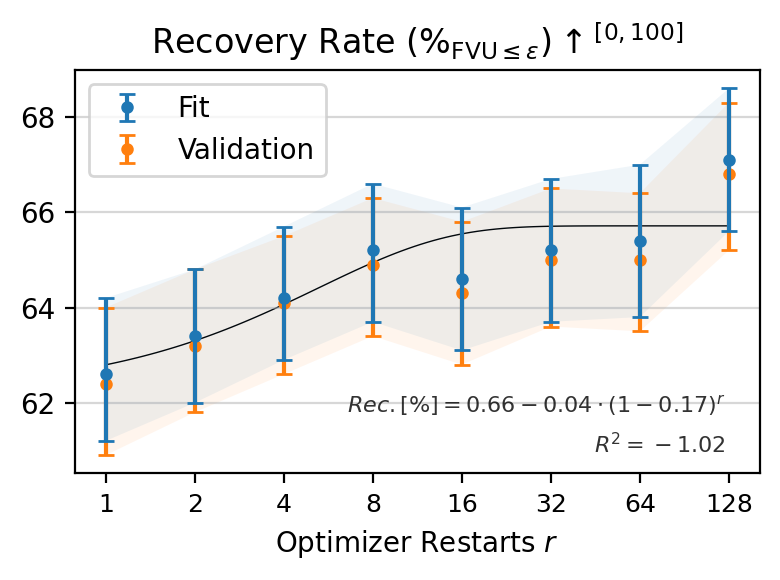

In [50]:
show_metric = 'FVU-eps_accuracy'
objective = 'max'
y_label = 'Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)'
bounds = (0, 100)
sub_metric = 'mean'
factor = 100
yscale = 'linear'
ylim = None

x = [int(model.split('/')[1].split('-')[0][5:]) for model in MODELS]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)

showed_val_legend = False

show_metrics = [show_metric]
if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
    show_metrics.append(f'{show_metric}_val')

for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
    y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
    y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
    y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

    ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3, zorder=3 + len(show_metrics) - k, label=label)
    sorted_indices = np.argsort(x)
    ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07, zorder=len(show_metrics) - k)

if not showed_val_legend:
    ax.legend(loc='upper left')
    showed_val_legend = True

ax.set_xscale('log', base=2)
arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
ax.set_title(y_label + f'{arrow}')
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=9)

if show_metric == 'FVU-eps_accuracy':
    x_logspace = np.logspace(np.log2(min(x)), np.log2(max(x)), 100, base=2)
    y_fit = fit_fn(x_logspace, *popt) * factor
    ax.plot(x_logspace, y_fit, color='black', linewidth=0.5, label='Fit', zorder=1, alpha=1)
    annotation_str = f'$Rec. [\\%] = {popt[0]:.2f} - {popt[1]:.2f} \\cdot (1 - {popt[2]:.2f})^r$'
    ax.annotate(annotation_str, (0.95, 0.15), xycoords='axes fraction', fontsize=8, alpha=0.8, ha='right')
    ax.annotate(f'$R^2 = {1- fit_fvu:.2f}$', (0.95, 0.05), xycoords='axes fraction', fontsize=8, alpha=0.8, ha='right')

ax.grid(alpha=0.5, axis='y', zorder=2)

ax.set_yscale(yscale)

ax.set_ylim(ylim)

ax.set_xlabel('Optimizer Restarts $r$')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_restarts', create=True, filename='analysis_restarts_errorbars.svg'))